In [1]:
from utils.data import DataGenerator, train_test_split, collate_fn, DataScaler
import pandas as pd

from model.modules import SSIBEncoder, CATEncoder, DNN, Binder
import pickle, os, tqdm, gc, torch
from utils.trainer import SSIBTrainer, MultipleTrainer
from torch.utils.data import DataLoader
from torch.optim import AdamW
from torch import nn
import numpy as np
from sklearn.metrics import r2_score, mean_absolute_error
from torch.utils.tensorboard import SummaryWriter

/home/jhyang/anaconda3/envs/poly/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Data load

In [2]:

root = '/home/jhyang/WORKSPACES/MODELS'
DG = DataGenerator(None, None)
Scaler = DataScaler()
target_names = pd.read_csv('/home/jhyang/WORKSPACES/DATA/polymers/QM9/target.csv').columns
UDG = DG.load('../unscreened_dataset.qm9.pkl')
SDG = DG.load('../screened_dataset.qm9.pkl')
VDG = DG.load('../vscreened_dataset.qm9.pkl')

datasets = {
    'V_wF_24k'  :train_test_split(VDG.data, n_train=50000, include_f=True, seed=100),
    'V_wF_99k'  :train_test_split(VDG.data, n_train=100000, include_f=True, seed=100),
    'V_wF_ALL'  :(VDG.data,) + train_test_split(VDG.data, n_train=100000, include_f=True, seed=100)[1:],
    'S_wF_24k'  :train_test_split(SDG.data, n_train=50000, include_f=True, seed=100),
    'S_wF_99k'  :train_test_split(SDG.data, n_train=100000, include_f=True, seed=100),
    'S_wF_ALL'  :(SDG.data,) + train_test_split(SDG.data, n_train=100000, include_f=True, seed=100)[1:],
    'U_wF_24k'  :train_test_split(UDG.data, n_train=50000, include_f=True, seed=100),
    'U_wF_99k'  :train_test_split(UDG.data, n_train=100000, include_f=True, seed=100),
    'U_wF_ALL'  :(UDG.data,) + train_test_split(UDG.data, n_train=100000, include_f=True, seed=100)[1:],
}

  Overwriting attribute : norm
  Overwriting attribute : ptable
  Overwriting attribute : ptbl_feat_name
  Overwriting attribute : data
  Setting new attribute : name_atom_feat
  Setting new attribute : name_bond_feat
  Setting new attribute : name_mol_feat
  Overwriting attribute : norm
  Overwriting attribute : ptable
  Overwriting attribute : ptbl_feat_name
  Overwriting attribute : data
  Setting new attribute : name_atom_feat
  Setting new attribute : name_bond_feat
  Setting new attribute : name_mol_feat
  Overwriting attribute : norm
  Overwriting attribute : ptable
  Overwriting attribute : ptbl_feat_name
  Overwriting attribute : data
  Setting new attribute : name_atom_feat
  Setting new attribute : name_bond_feat
  Setting new attribute : name_mol_feat


In [3]:

epochs = 2000
atom_net_params  = {
    'n_atom_feat':None,
    'n_bond_feat':None,
    'graph':None,
    'hidden_dim':64,
    'output_dim':32,
    'n_layer':4
}
mol_net_params  = {
    'input_dim':None,
    'hidden_dims':[256, 128],
    'output_dim':32,
}
hgib_net_params = {}

In [4]:
pt_epochs = 3000
ft_epochs = 3000
warmup = 500
root = '/home/jhyang/WORKSPACES/MODELS/fpoly/encoders/'
output_dim = 64
atom_net_params  = {
    'n_atom_feat':None,
    'n_bond_feat':None,
    'graph':None,
    'hidden_dim':64,
    'output_dim':output_dim,
    'n_layer':4
}
mol_net_params  = {
    'input_dim':None,
    'hidden_dims':[256, 256, 256],
    'output_dim':output_dim,
}
hgib_net_params = {
    'x1_dim':atom_net_params['output_dim'],
    'x2_dim':mol_net_params['output_dim'],
    'beta':1e-2,
    'hidden_dims':[256, 256]
}

early_stop = 300


In [5]:

for desc, (train, valid, test) in datasets.items():
    if desc.startswith('S'):
        atom_net_params['n_atom_feat'] = SDG.n_atom_feat
        atom_net_params['n_bond_feat'] = SDG.n_bond_feat
        mol_net_params['input_dim'] = SDG.n_mol_feat
    if desc.startswith('U'):
        atom_net_params['n_atom_feat'] = UDG.n_atom_feat
        atom_net_params['n_bond_feat'] = UDG.n_bond_feat
        mol_net_params['input_dim'] = UDG.n_mol_feat
    if desc.startswith('V'):
        atom_net_params['n_atom_feat'] = VDG.n_atom_feat
        atom_net_params['n_bond_feat'] = VDG.n_bond_feat
        mol_net_params['input_dim'] = VDG.n_mol_feat
    Scaler.train(collate_fn(train)[1])
    batch_size = 2048
#    for i, target_name in enumerate(target_names):
    train_data = Scaler.scale_data(train)
    valid_data = Scaler.scale_data(valid)
    test_data = Scaler.scale_data(test)
    print(desc)
    print(Scaler.avg.cpu().numpy())

V_wF_24k
[ 2.6037896e+00  7.5421753e+01 -2.4045466e-01  1.3369700e-02
  2.5184807e-01  1.1703269e+03  1.4839421e-01  3.1616240e+01
 -4.1265488e+02 -4.1264642e+02 -4.1264545e+02 -4.1268829e+02]
V_wF_99k
[ 2.6039848e+00  7.5533035e+01 -2.4043302e-01  1.3808377e-02
  2.5228509e-01  1.1715746e+03  1.4875150e-01  3.1654612e+01
 -4.1230725e+02 -4.1229874e+02 -4.1229779e+02 -4.1234073e+02]
V_wF_ALL
[ 2.6061907e+00  7.5469902e+01 -2.4044259e-01  1.3447128e-02
  2.5187203e-01  1.1704270e+03  1.4840780e-01  3.1625864e+01
 -4.1256619e+02 -4.1255771e+02 -4.1255676e+02 -4.1259967e+02]
S_wF_24k
[ 2.6037896e+00  7.5421753e+01 -2.4045466e-01  1.3369700e-02
  2.5184807e-01  1.1703269e+03  1.4839421e-01  3.1616240e+01
 -4.1265488e+02 -4.1264642e+02 -4.1264545e+02 -4.1268829e+02]
S_wF_99k
[ 2.6039848e+00  7.5533035e+01 -2.4043302e-01  1.3808377e-02
  2.5228509e-01  1.1715746e+03  1.4875150e-01  3.1654612e+01
 -4.1230725e+02 -4.1229874e+02 -4.1229779e+02 -4.1234073e+02]
S_wF_ALL
[ 2.6061907e+00  7.5469902

KeyboardInterrupt: 

In [68]:
subset_dicts = {}
for k in ['24k', '99k', 'ALL']:
    t, _, _ = datasets['V_wF_'+k]
    x = collate_fn(t)[1]
    subset_dicts[k] = x.cpu().numpy().T
subsets = []
for i in range(x.shape[1]):
    subset = {
        '24k':subset_dicts['24k'][i],
        '99k':subset_dicts['99k'][i],
#        'ALL':subset_dicts['ALL'][i],
    }
    subsets.append(subset)

In [35]:
targets = x[1].cpu().numpy().T

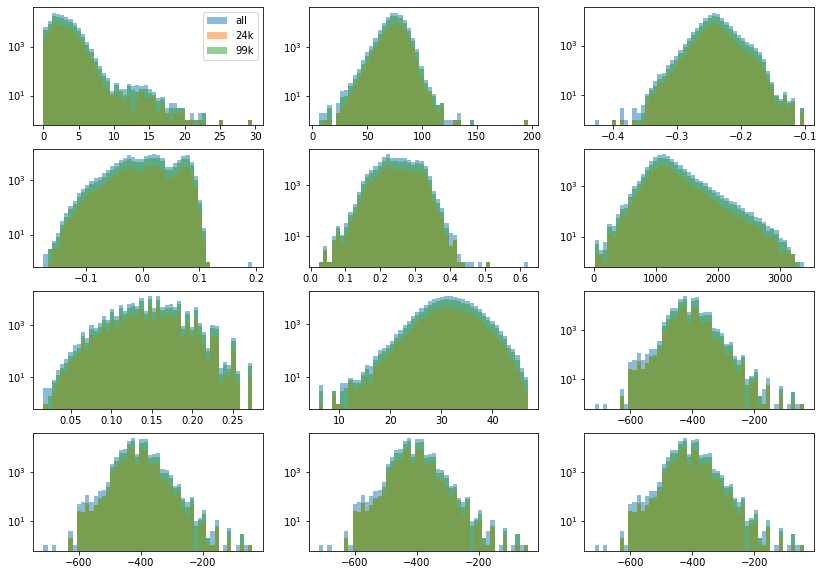

In [69]:
import matplotlib.pyplot as plt
%matplotlib inline

f, axs = plt.subplots(4, 3, figsize=(14,10))
for ax, t, subset in zip(axs.reshape(-1), targets, subsets):
    _, bins, _ = ax.hist(t, bins=50, label='all', alpha=0.5)
    for k,x in subset.items():
        ax.hist(x, bins=bins, alpha=0.5, label=k)
    ax.set_yscale('log')
axs[0,0].legend(loc='upper right')

In [76]:
from utils.data import DataScaler
import torch
scale_24 = DataScaler()
scale_24.train(torch.tensor(subset_dicts['24k'].T))
scale_99 = DataScaler()
scale_99.train(torch.tensor(subset_dicts['99k'].T))
scale_aa = DataScaler()
scale_aa.train(torch.tensor(subset_dicts['ALL'].T))

In [79]:
scale_24.avg, scale_99.avg

(tensor([ 2.6038e+00,  7.5422e+01, -2.4045e-01,  1.3370e-02,  2.5185e-01,
          1.1703e+03,  1.4839e-01,  3.1616e+01, -4.1265e+02, -4.1265e+02,
         -4.1265e+02, -4.1269e+02]),
 tensor([ 2.6040e+00,  7.5533e+01, -2.4043e-01,  1.3808e-02,  2.5229e-01,
          1.1716e+03,  1.4875e-01,  3.1655e+01, -4.1231e+02, -4.1230e+02,
         -4.1230e+02, -4.1234e+02]))